In [1]:
%pip install nltk
%pip install scikit-learn
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import nltk
#I added this because of a lookup error for nltk
#nltk.download()
import sklearn
import matplotlib.pyplot as plt
import csv

In [3]:
#get the data from the kaggledata_archive for n-grams (using all-data.csv)
import re
#Changed it from a panda dataframe into a csv file which then returns as a list of string
regex = re.compile(r'[^\w\s]*') #regular expression to get rid of punctuation marks
with open('./kaggledata_archive/all-data.csv', encoding='latin-1') as original_csv: 
    financial_csv = csv.reader(original_csv)
    finance = list(financial_csv)

#get rid of the first column(sentiment) in csv        
csv_data: list[str] = [t[1] for t in finance]
csv_data: list[str] = [re.sub(r'[^\w\s]*', '', _) for _ in csv_data] #using regular expression to replace punctuations with white space



In [4]:
#Task 1: N-gram Generation
from nltk.tokenize import word_tokenize
from collections import Counter

#Task 1: N-gram Generation
def n_gram_generation(csv_data: list[str], number_of_words: int) -> tuple[tuple[str]]:
    """A function that extracts a certain words from the csv file 
        into a list of tuple of strings

    Args:
        csv_file (pandas dataframe): a dataframe of a csv file containing all the financial headlines
        number_of_words (integer): the number of words to put in each tuple element 

    Returns:
        n_grams (tuple of tuple of strings): a list of a tuple of all the words from the csv_file for each n-gram model
    """
    #for text in csv_file: Only iterating through the first row for some reason
        #tokens = word_tokenize(text)

    tokens: list[str] = []
    for line in csv_data:
        tokens.extend(word_tokenize(line))
    ngrams = tuple(tuple(tokens[i : i + number_of_words]) for i in range(len(tokens) - number_of_words + 1))
    return ngrams
    
unigram: tuple[tuple[str]] = n_gram_generation(csv_data, 1)
bigram: tuple[tuple[str]] = n_gram_generation(csv_data, 2)
trigram: tuple[tuple[str]] = n_gram_generation(csv_data, 3)

#Create the word cloud with the top 10 words for each model
unigram_frequency: list[tuple[str]] = Counter(unigram).most_common(10)
#print(unigram_frequency)
#Rewrite this for word cloud visualization
bigram_frequency: list[tuple[str]] = Counter(bigram).most_common(10)
#print(bigram_frequency)
trigram_frequency: list[tuple[str]] = Counter(trigram).most_common(10)
#print(trigram_frequency)


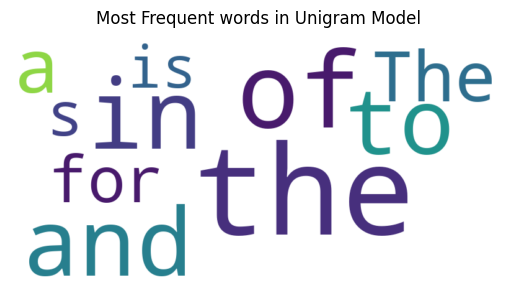

In [5]:
#Display the word cloud for unigram model
from wordcloud import WordCloud
#convert unigram_frequency into a dictionary
unigram_dict_frequency = {k[0]: v for k, v in unigram_frequency}
unigram_wordCloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unigram_dict_frequency)
plt.imshow(unigram_wordCloud, interpolation='bilinear')
plt.title("Most Frequent words in Unigram Model")
plt.axis("off")
plt.show()

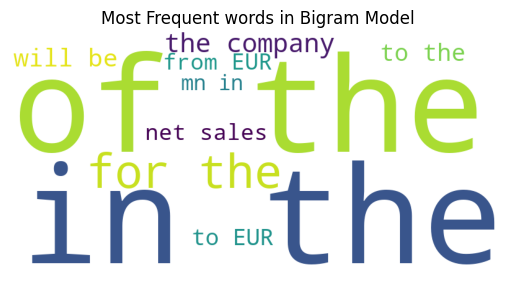

In [6]:
#Display the word cloud for bigram model
from wordcloud import WordCloud
#Convert from lis[tuple[str]] to dictionary to make it easier for wordcloud
bigram_dict_frequency = {' '.join(bigram): count for bigram, count in bigram_frequency}
bigram_wordCloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_dict_frequency)
plt.imshow(bigram_wordCloud)
plt.title("Most Frequent words in Bigram Model")
plt.axis("off")
plt.show()

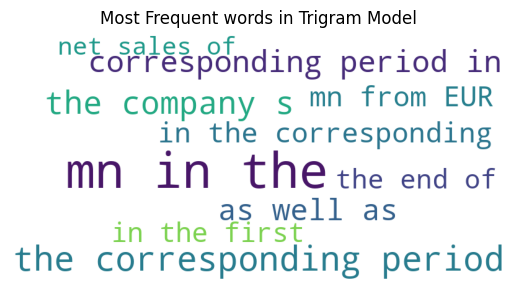

In [7]:
#Display the word cloud for trigram model
from wordcloud import WordCloud
trigram_dict_frequency = {' '.join(trigram): count for trigram, count in trigram_frequency}
trigram_wordCloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(trigram_dict_frequency)
plt.imshow(trigram_wordCloud)
plt.title("Most Frequent words in Trigram Model")
plt.axis("off")
plt.show()

In [8]:
#Task 2: N-Gram Modeling
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import defaultdict
import math

#This is the function to calculate perplexity
def calculate_perplexity(test_text_series: pd.Series, n: int ,cond_prob: dict) -> float:
    """
    A function that returns the perplexity of each n-gram model
    using text from the test set and the conditional probabilities calculated in n_gram model
    
    Args:
    test_text_series (panda Series): panda Series that contains a small percentage of financial headlines text not used in n_gram_model
    n (int): an integer indicating the number of n-grams(1 for unigram, 2 for bigram, 3 for trigram, etc.)
    cond_prob (dict): a dictionary containing the probabilities of the n-grams with the probability of each being 
    
    Returns:
    perplexity (float): a float representing the perplexity of each model
    """
    word_count = 0 #Number of predicted words in the test_set
    log_prob_sum = 0 #summation of the log of all probabilities
    tokens = []
    for lines in test_text_series:
        line_tokens = lines.split()
        tokens.extend(['<s>'] * (n-1) + line_tokens + ['</s>']) #Add the start and end sentence token like before
        word_count += len(line_tokens) + 1
    
    for i in range(len(tokens) - n+1):
        n_gram = tuple(tokens[i:i+n])
        #get the conditional probability of each n-gram to to 4th decimal place just in case for unseen data (fix with laplace smoothing later)
        prob = cond_prob.get(n_gram,1e-6) 
        log_prob_sum += math.log(prob)
  
    #perplexity = exp (-avg log probability)    
    perplexity = math.exp(-log_prob_sum / word_count)
    return perplexity

def n_gram_model(text_series:pd.Series, n: int) -> tuple[dict, dict, dict]:
    """
    A function that creates a n-gram model trained on a pandas dataframe/Series
    
    Args:
    text (panda Series): panda Series that contains the financial headlines text
    n (int): integer of how many n-grams to create (1 for unigram, 2 for bigram, etc.)
    
    Returns:
    a tuple containing three dictionaries:
        ngram_frequency (dict): a dictionary containing all the n-grams and their frequency (number of times they appear)
        context_frequency (dict): a dictionary of the n-grams and their frequency(number of times they occur)
        conditional_probability (dict): a dictonary containing the probability of the n-grams based on previous word
    """
    ngram_frequency = defaultdict(int) #number of times a n-gram appears in the datset
    context_frequency = defaultdict(int) #number of times each n-1(context) words of n-gram appear (This is for the bigram and trigram)
    conditional_probability = dict()
    
    #Need to go through every line in the series and split it
    tokens = []
    for line in text_series:
        line_tokens = line.split()
        tokens.extend(['<s>']  * (n-1) + line_tokens + ['</s>'])  #Add the start and end sentence token like in the textbook
    
   
    for i in range(len(tokens) - n+1):
        ngram = tuple(tokens[i: i + n])
        context = tuple(tokens[i: i + n-1])
        #increment each time a n-gram appears
        ngram_frequency[ngram] += 1 
        #increment each time a context appears
        context_frequency[context] += 1
    
    #Look at the frequency for all n_gram to compute the conditonal probability    
    for n_gram, frequency in ngram_frequency.items():
        context = n_gram[:-1] #extract the context of each n_gram frequency
        #frequency/context which stores the n-grams with their probability
        conditional_probability[n_gram] = frequency/context_frequency[context]
        
    return dict(ngram_frequency), dict(context_frequency), conditional_probability

#use pandas dataframe to read in csv file now
financial_df = pd.read_csv('./kaggledata_archive/all-data.csv', encoding='latin-1', header=None)
#drop the sentiment column
financial_df = financial_df.drop(columns=[0])

#Do regular expressions to get rid of punctuations and lower case
financial_df[1] = financial_df[1].str.lower()

pattern = re.compile(r'[^\w\s]*') #regular expression to get rid of punctuation marks

financial_df = financial_df.replace(pattern,'',regex=True)

#print(financial_df.head()) to see if above statements came out the way I wanted

#Split the dataframe into training set and test set (test_size =0.2)
training_set,test_set = train_test_split(financial_df[1], test_size=0.2, random_state=42)

#print(training_set.head()) for sanity
#print(test_set.head()) for sanity

#get just the text from the training_set and test_set
training_text = training_set.astype(str)
test_text = test_set.astype(str)

#Train the n-gram models
unigram_model, unigram_context, unigram_cond_prob = n_gram_model(training_text, 1)
bigram_model, bigram_context, bigram_cond_prob = n_gram_model(training_text, 2)
trigram_model, trigram_context, trigram_cond_prob = n_gram_model(training_text, 3)


In [9]:
#Printing the perplexity of each n-gram model
print(f"Perplexity for unigram model is: {calculate_perplexity(test_text, 1, unigram_cond_prob)}")
print(f"Perplexity for bigram model is: {calculate_perplexity(test_text, 2,  bigram_cond_prob)}")
print(f"Perplexity for trigram model is: {calculate_perplexity(test_text, 3, trigram_cond_prob)}")

Perplexity for unigram model is: 1130.2788150724166
Perplexity for bigram model is: 2086.4252050747464
Perplexity for trigram model is: 31159.56554204029


In [10]:
#Task 3: Handling unseen n-grams

def laplace_smoothing_count(text:pd.Series, n: int) -> tuple[dict, dict, int]:
    """
    This is a modified version of the n_gram_model (copied over and then modified)
    it returns the 

    Args:
        text (pd.Series): the training text comprised of financial headlines
        n (int): number of n-grams to create

    Returns:
        A tuple containing three elements:
            ngram_count (dict): a dictionary containing all the n-grams and the number of times they appear
            context_frequency (dict): a dictionary of the context (n|n-1) and their frequency
            vocab_size (int): the size of the vocabulary set
    """
    ngram_counts = defaultdict(int) #number of times a n-gram appears in the datset
    context_frequency = defaultdict(int) #number of times each n-1(context) words of n-gram appear (This is for the bigram and trigram)
    vocab = set()
    
    #Need to go through every line in the series and split it
    tokens = []
    for line in text:
        line_tokens = line.split()
        tokens.extend(['<s>'] * (n-1) + line_tokens + ['</s>'])  #Add the start and end sentence token like in the textbook
        vocab.update(tokens)
   
        for i in range(len(tokens) - n+1):
            ngram = tuple(tokens[i: i + n])
            context = tuple(tokens[i: i + n-1])
            #increment each time a n-gram appears
            ngram_counts[ngram] += 1 
            #increment each time a context appears
            context_frequency[context] += 1
    vocab_size = len(vocab)
    return dict(ngram_counts), dict(context_frequency), vocab_size

unigram_counts, unigram_context, unigram_vocab_size = laplace_smoothing_count(training_text, 1)
bigram_counts, bigram_context, bigram_vocab_size = laplace_smoothing_count(training_text, 2)
trigram_counts, trigram_context, trigram_vocab_size = laplace_smoothing_count(training_text, 3)

In [13]:
#Calculate the perplexity of each model now with laplace smoothing
#This is the function to calculate perplexity
import math

def calculate_laplace_smoothing(ngram:tuple, ngram_counts: dict, context_frequency:dict, vocab_size:int) -> float:
    """
    Returns the conditional probability of n-gram models with laplace smoothing added

    Args:
        ngram (tuple): a tuple of words containing a single g-gram for a model (to use for perplexity)
        ngram_counts (dict): a dictionary containing the n_grams and its frequency
        context_frequency (dict): a dictionary containing the context of each n-gram model and its frequency
        vocab_size (int): the number of vocabulary in test/training test

    Returns:
        float: the conditional proabability with laplace smoothing applied
    """
    context= ngram[:-1]
    count = ngram_counts.get(ngram,0)
    context_count = context_frequency.get(context, 0)
    laplace_cond_prob = (count + 1) / (context_count + vocab_size)
    return laplace_cond_prob

def calculate_perplexity(test_text_series: pd.Series, n: int, ngram_counts: dict, context_counts: dict, vocab_size: int) -> float:
    """
    A function that returns the perplexity of each n-gram model
    using text from the test set and the conditional probabilities calculated in n_gram model
    
    Args:
    test_text_series: panda Series that contains a small percentage of financial headlines text not used in n_gram_model
    n: an integer indicating the number of n-grams(1 for unigram, 2 for bigram, 3 for trigram, etc.)
    cond_prob: a dictionary containing the probabilities of the n-grams with the probability of each being 
    
    Returns:
    perplexity (float): a float representing the perplexity of each model
    """
    word_count = 0 #Number of predicted words in the test_set
    log_prob_sum = 0 #summation of the log of all probabilities
    
    tokens = []
    for lines in test_text_series:
        line_tokens = lines.split()
        tokens.extend(['<s>'] * (n-1) + line_tokens + ['</s>']) #Add the start and end sentence token like before
        word_count += len(line_tokens) + 1
    
    for i in range(len(tokens) - n+1):
        ngram = tuple(tokens[i:i+n])
        #get the conditional probability of each n-gram to to 4th decimal place just in case for unseen data (fix with laplace smoothing later)
        prob = calculate_laplace_smoothing(ngram, ngram_counts, context_counts, vocab_size)
        log_prob_sum += math.log(prob)
  
    #perplexity = exp (-avg log probability)    
    perplexity = math.exp(-log_prob_sum / word_count)
    return perplexity

print(f"The perplexity of the unigram model with laplace smoothing: {calculate_perplexity(test_text, 1, unigram_counts, unigram_context, unigram_vocab_size)} ")
print(f"The perplexity of the unigram model with laplace smoothing: {calculate_perplexity(test_text,2, bigram_counts, bigram_context, bigram_vocab_size)}")
print(f"The perplexity of the unigram model with laplace smoothing: {calculate_perplexity(test_text, 3, trigram_counts, trigram_context, trigram_vocab_size)}")

The perplexity of the unigram model with laplace smoothing: 1628.2858418893036 
The perplexity of the unigram model with laplace smoothing: 859.6886789384243
The perplexity of the unigram model with laplace smoothing: 2050.6766111623724


Here the perplexity changes when laplace smoothing is applied. \
The perplexity increased with each model without laplace smoothing. \
However, compared to laplace smoothing (rounding up decimals): \\

Unigram: 1130.3 (without laplace smoothing) , 1628.3 (with laplace smoothing) means that the smoothing got worse since the perplexity increased.\
Bigram : 2086.4  (without laplace smoothing), 859.7 (with laplace smoothing) measn that the smoothing made the perplexity better since it lowered. \
Trigram: 31159.6 (without laplace smoothing), 2050.7 (with laplace smoothing) means that the smoothing made the perplexity very much better since it dropped quite a lot!

In [ ]:
#Task 4: Interpolation
def interpolation(ngram, unigram_prob, bigram_prob, trigram_prob, weights) -> float:
    """_summary_

    Args:
        ngram (tuple): a tuple of 3 words (w_i-2, w_i-1, w_i)
        unigram_prob (dict): a dictionary of the unigram probabilities
        bigram_prob (dict): a dictionary of the bigram probabilities
        trigram_prob (dict): a dictionary of the trigram probabilities
        weights (list): a list of interpolation weights for eahc n-gram

    Returns:
        float: the interpolated probability of the n-gram model
    """
    w_i = ngram[-1] #Gets the last word
    bigram = ngram[1:] #Gets the last two words
    unigram = (w_i,) #single word tuple
    
    p1 = unigram_prob.get(unigram, 1e-6) #probability of unigram model
    p2 = bigram_prob.get(bigram,1e-6) #probability of bigram model
    p3 = trigram_prob.get(trigram,1e-6) #probability of trigram model
    
    return (weights[0] * p1) + (weights[1] * p2) + (weights[2] * p3)
    
def calculate_perplexity_interpolation(test_text: pd.Series, n: int,):
    word_count = 0
    log_prob_sum = 0
    tokens = []
    for lines in test_text:
        line_tokens = lines.split()
        tokens.extend(['<s>'] * (n-1) + line_tokens + ['</s>'])
        
    for i in range(len(tokens) - n + 1):
        ngram = tuple(tokens[i:i+n])
        prob = interpolation(ngram, unigram_prob, bigram_prob, trigram_prob, lambdas)
        log_prob_sum += math.log(prob)
    
    perplexity = math.exp(-log_prob_sum / word_count)
    return perplexity

#Plotting the interpolated models vs the laplace smoothed models
weights = [0.7, 0.2, 0.1]
print(f"Interpolated model complexity with unigram weight:{weights[0]}, bigram weight: {weights[1]}, trigram_weights{weights[2]}, the perplexity is {calculate_perplexity_interpolation()}")